<img src="./logo_UNSAM.jpg" align="right" width="150" />

# Tarea semanal 5 
#### Análisis y procesaimento de señales
**Kala Ariadna Guevara, Carola Piazze Vicini**

## Introducción
En este trabajo se analizaron señales reales mediante la estimación de su densidad espectral de potencia. 
Se implementó el método de estimación de Welch, un procedimiento que consiste en dividir la señal en varios segmentos superpuestos, aplicar a cada uno una ventana de ponderación (como Hanning o Hamming) y luego calcular la transformada rápida de Fourier (FFT) de cada segmento. La aplicación de la ventana suaviza los extremos del segmento reduciendo los saltos bruscos que aparecen al cortarlo, y así disminuye el spectral leakage. Luego se calcula el periodograma de cada segmento (el módulo cuadrado de la FFT) y se realiza un promedio entre todos ellos, con el propósito de suavizar las fluctuaciones.

$$
\hat{P}_{xx}^{(Welch)}(f) = \frac{1}{K} \sum_{k=1}^{K} \frac{1}{U} 
\left| \text{FFT}\{ w(n) \, x_k(n) \} \right|^2
$$

donde:
- $ K $: número de segmentos,
- $ w(n) $: ventana aplicada a cada segmento,
- $ U = \frac{1}{N} \sum_{n=0}^{N-1} w^2(n) $: factor de normalización de la ventana,
- $ x_k(n) $ : muestra n-ésima del segmento k,
- y $\hat{P}_{xx}^{(Welch)}(f)$: estimación de la densidad espectral de potencia.
## Desarrollo
  A partir de las PSD obtenidas, se realizó una estimación del ancho de banda efectivo de cada señal, es decir, el rango de frecuencias en el que se concentra la mayor parte de la potencia. Este análisis permite comparar las señales entre sí y evaluar su comportamiento espectral.

La función `estimar_ancho_de_banda(f, Pxx, porcentaje=0.995)` encuentra la frecuencia hasta la cual está contenido el porcentaje (0.995) de la energía total del espectro y devuelve el ancho de banda desde la frecuencia mínima hasta esa frecuencia de corte. Consiste en calcular la suma acumulada de la PSD a lo largo de las frecuencias, que se puede interpretar como la energía total contenida hasta cada frecuencia `f[i]`. Luego se normaliza y se busca el primer índice donde la energía acumulada normalizada alcanza o supera el porcentaje solicitado.

Para el método de Welch se utiliza una función de `scipy.signal`. Como su finalidad fue explicada en la introducción, solo se darán explicaciones para los argumentos menos conocidos. Entre ellos:

- `nperseg`: indica la longitud de cada segmento en muestras; un valor mayor de `nperseg` proporciona mejor resolución.
- `noverlap`: número de muestras de solapamiento entre segmentos; el solapamiento mejora la varianza del estimador.
- `scaling='density'`: especifica que la PSD devuelta (`Pxx`) tendrá unidades de potencia por Hz (densidad), no potencia total por bin.

Para los archivos de audio (como la voz de Mariano, el silbido y La Cucaracha), se convierten a mono si originalmente son estéreo. Primero se verifica con un bucle.

if wav1.ndim > 1:
    wav1 = wav1[:, 0]

Si wav1 tiene más de una dimensión (ndim > 1), se detecta que el audio es multicanal. En ese caso, se toma solo la primera columna o canal y se reasigna wav1 a ese vector unidimensional, descartando los demás canales. Este paso es necesario porque, si una señal estéreo con canales similares se analiza por separado, la potencia total aparentará ser el doble en comparación con un solo canal.

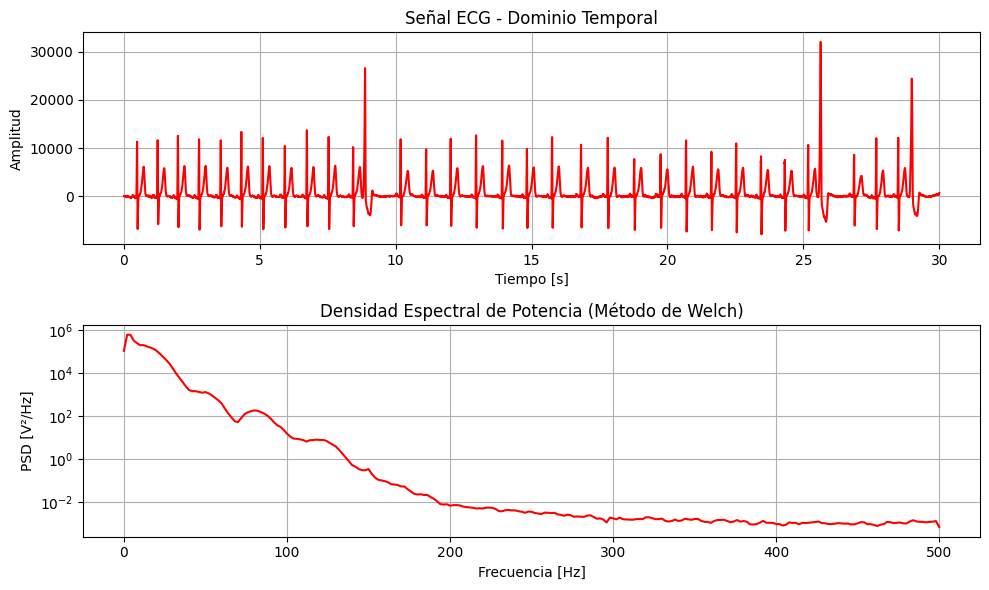


ANCHO DE BANDA ESTIMADO:
________________________________________________________________________________________
[ECG]        | 38.00 Hz (desde 0.00 Hz hasta 38.00 Hz)


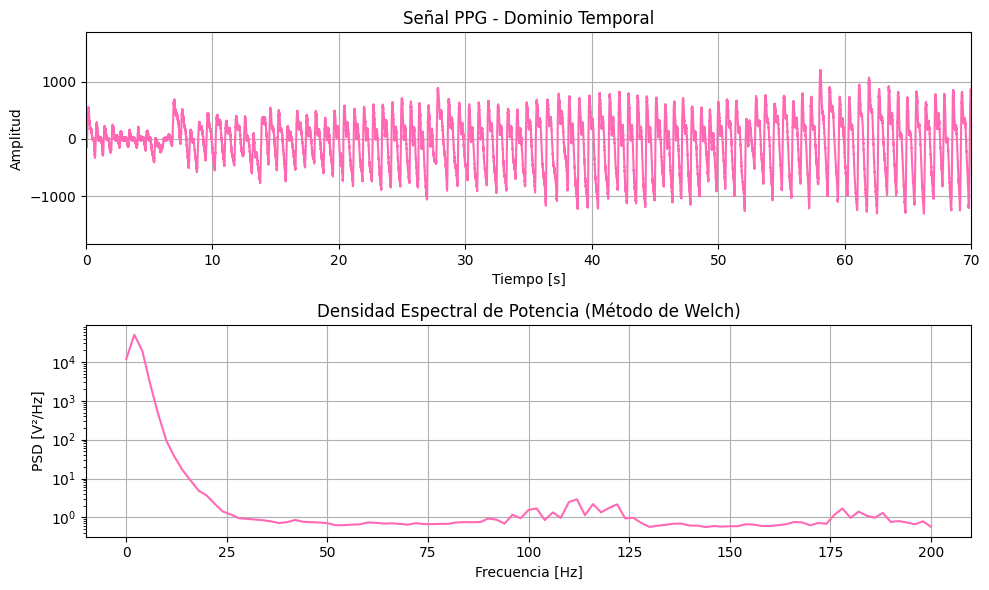

[PPG]        | 8.00 Hz (desde 0.00 Hz hasta 8.00 Hz)


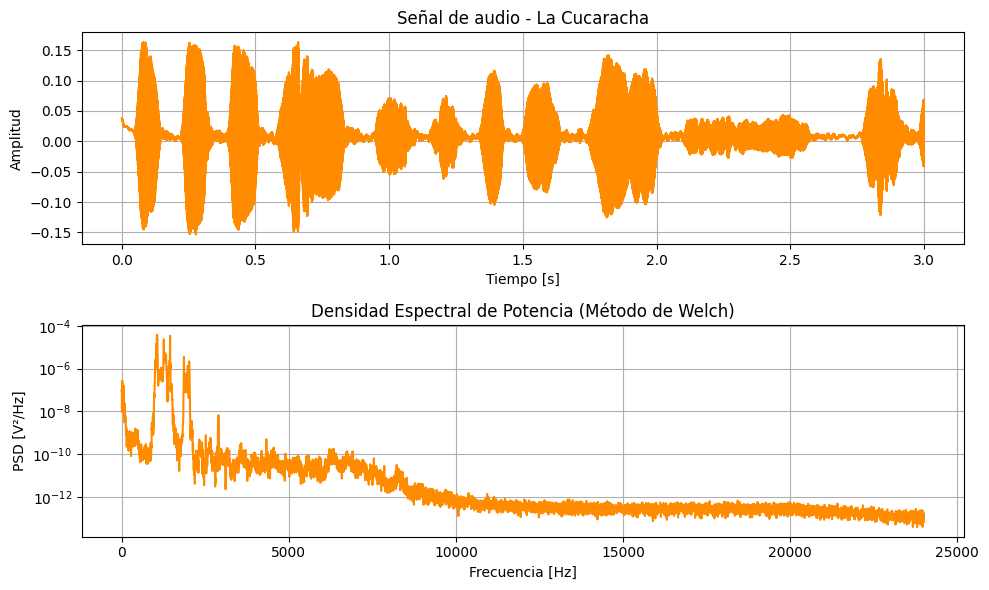

[La Cucaracha]   | 2022.00 Hz (desde 0.00 Hz hasta 2022.00 Hz)


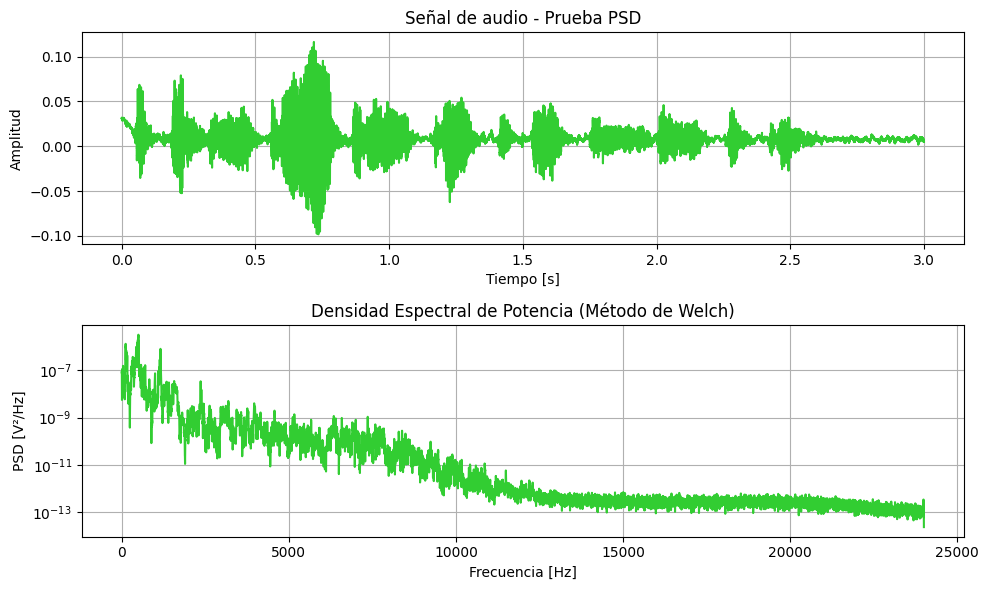

[Prueba PSD]   | 3970.00 Hz (desde 0.00 Hz hasta 3970.00 Hz)


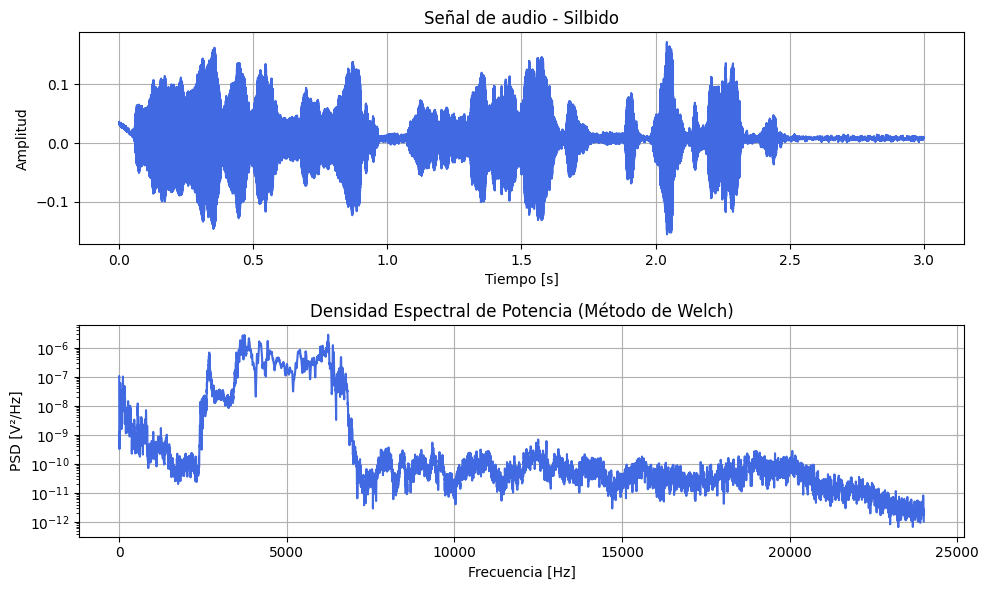

[Silbido]   | 6682.00 Hz (desde 0.00 Hz hasta 6682.00 Hz)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import scipy.io as sio

# FUNCION PARA ESTIMAR ANCHO DE BANDA PARA EL PUNTO 2
def estimar_ancho_de_banda(f, Pxx, porcentaje=0.995):
    # Normalizar la densidad espectral para obtener energía relativa
    energia_acum = np.cumsum(Pxx)
    energia_acum_norm = energia_acum / energia_acum[-1]
    # Buscar la frecuencia donde se alcanza el porcentaje deseado (por defecto 99.5%)
    indice_corte = np.where(energia_acum_norm >= porcentaje)[0][0]
    f_corte = f[indice_corte]
    # El ancho de banda va desde 0 Hz hasta esa frecuencia de corte
    ancho_banda = f_corte - f[0]
    return ancho_banda, f[0], f_corte


#%% ECG
fs = 1000#Hz
ecg = np.load('ecg_sin_ruido.npy')

f, Pxx = sig.welch(ecg, fs=fs, window='hann', nperseg=fs//2, noverlap=fs//4, scaling='density')
t = np.arange(len(ecg)) / fs

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, ecg, color='red')
plt.title("Señal ECG - Dominio Temporal")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.semilogy(f, Pxx, color='red')
plt.title("Densidad Espectral de Potencia (Método de Welch)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [V²/Hz]")
plt.grid(True)
plt.tight_layout()
plt.show()

bw_ecg, fmin_ecg, fmax_ecg = estimar_ancho_de_banda(f, Pxx)
print("\nANCHO DE BANDA ESTIMADO:")
print("________________________________________________________________________________________")
print(f"[ECG]        | {bw_ecg:.2f} Hz (desde {fmin_ecg:.2f} Hz hasta {fmax_ecg:.2f} Hz)")

#%% PPG 
fs = 400#Hz
ppg = np.load('ppg_sin_ruido.npy')

f, Pxx = sig.welch(ppg, fs=fs, window='hann', nperseg=fs//2, noverlap=fs//4, scaling='density')
t = np.arange(len(ppg)) / fs

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, ppg, color='hotpink')
plt.title("Señal PPG - Dominio Temporal")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.xlim(0,70)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.semilogy(f, Pxx, color='hotpink')
plt.title("Densidad Espectral de Potencia (Método de Welch)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [V²/Hz]")
plt.grid(True)
plt.tight_layout()
plt.show()

bw_ppg, fmin_ppg, fmax_ppg = estimar_ancho_de_banda(f, Pxx)
print(f"[PPG]        | {bw_ppg:.2f} Hz (desde {fmin_ppg:.2f} Hz hasta {fmax_ppg:.2f} Hz)")

#%% AUDIOS DEL SILBIDO, CUCA Y MARIANO HABLANDO
fs1, wav1 = sio.wavfile.read('la cucaracha.wav')
fs2, wav2 = sio.wavfile.read('prueba psd.wav')
fs3, wav3 = sio.wavfile.read('silbido.wav')

#Convertir a mono si es estereo, de dos a 1 canal, asi no se me duplica la energia
if wav1.ndim > 1: wav1 = wav1[:, 0]
if wav2.ndim > 1: wav2 = wav2[:, 0]
if wav3.ndim > 1: wav3 = wav3[:, 0]

def analizar_audio(senal, fs, nombre, color):
    f, Pxx = sig.welch(senal, fs=fs, window='hann', nperseg=fs//2, noverlap=fs//4, scaling='density')
    t = np.arange(len(senal)) / fs

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, senal, color=color)
    plt.title(f"Señal de audio - {nombre}")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.semilogy(f, Pxx, color=color)
    plt.title("Densidad Espectral de Potencia (Método de Welch)")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("PSD [V²/Hz]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    bw, fmin, fmax = estimar_ancho_de_banda(f, Pxx)
    print(f"[{nombre}]   | {bw:.2f} Hz (desde {fmin:.2f} Hz hasta {fmax:.2f} Hz)")

analizar_audio(wav1, fs1, "La Cucaracha", "darkorange")
analizar_audio(wav2, fs2, "Prueba PSD", "limegreen")
analizar_audio(wav3, fs3, "Silbido", "royalblue")

## Análisis
**ECG - electrocardiograma**
El gráfico temporal muestra una forma clásica del electrocardiograma, con picos repetitivos y bien definidos. Se observan dos picos algo disruptivos, más altos que el resto, lo que podría indicar una leve arritmia cardíaca o
La señal es periódica y cambia lentamente sin oscilaciones rápidas, lo que en frecuencia significa que la mayor parte de su potencia está concentrada en frecuencias bajas.
Esto puede verse claramente en el dominio espectral, el gráfico de la PSD muestra el máximo cerca de cero en el eje de frecuencias.
A partir del criterio de energía acumulada, el ancho de banda estimado resulta del orden de 30–50 Hz.
La señal fue muestreada a 1000Hz.

**PPG - fotopletismografía**
En el dominio temporal la señal presenta oscilaciones periodicas bien definidas, con picos pronunciados correspondientes a los pulsos cardíacos. Se observan variaciones de amplitud y cierta irregularidad en la forma de los pulsos, lo que podría indicar que el método no es tan preciso y captura componentes adicionales además de la frecuencia cardíaca fundamental.
En el dominio de frecuencia, la PSD muestra un pico dominante en las frecuencias bajas, que corresponde a la frecuencia cardíaca promedio. A partir de ahí decar rápidamente, aunque todavía se observa algo de contenido energético en frecuencias mayores, de 100 a 125 Hz, y de 175 a 200 Hz.
El cálculo del ancho de banda efectivo indica que la potencia útil de la señal está concentrada desde 0 Hz hasta aproximadamente 8 Hz.
La señal fue muestreada a 400Hz.

**Señales de audio**
Las tres señales acústicas analizadas presentan un comportamiento espectral mucho más amplio que las señales biomédicas, ya que contienen información significativa en frecuencias  más altas. Por este motivo, se emplean frecuencias de muestreo mucho mayores (48kHz) esto permite representar correctamente las variaciones rápidas del sonido sin pérdida de información.
En el caso de La Cucaracha, la señal musical muestra una forma temporal compleja y una densidad espectral de potencia extendida hasta varios kilohertz. Su ancho de banda estimado ronda los 10 kHz, lo que refleja la gran variedad de contenidos de frecuencia, coherente con las características de las señales musicales.
La señal Prueba PSD, que corresponde a una grabación de voz, muestra variaciones suaves y pausadas en el tiempo, propias del habla. En el dominio frecuencial, su potencia se concentra principalmente entre 300 Hz y 4 kHz, que es el rango donde se encuentran la mayoría de los sonidos que permiten distinguir y entender las palabras. A frecuencias mayores, la potencia disminuye de forma notable.
La señal correspondiente al silbido muestra una forma de onda algo más estable y sostenida en el tiempo. En el dominio de la frecuencia, su densidad espectral de potencia presenta un sector bien definido alrededor de los 6.6 kHz, lo que indica que la mayor parte de la energía está concentrada en una banda angosta. Este comportamiento es característico de sonidos tonales con frecuencia dominante alta, en contraste con la voz hablada, que distribuye su potencia en un rango más amplio y de menor frecuencia.



## Conclusión
El análisis espectral permitió comparar el contenido en frecuencia de distintas señales reales, biomédicas y acústicas, y entender su comportamiento en el dominio de la potencia.
Las señales fisiológicas, como el ECG y el PPG, mostraron espectros concentrados en frecuencias bajas (por debajo de 50 Hz y 10 Hz respectivamente), lo que refleja la naturaleza lenta y periódica de los procesos biológicos que representan.
Por otro lado, las señales de audio mostraron un espectro mucho más extendido, con contenido energético distribuido en un rango de frecuencias considerablemente mayor.
Los resultados parecen demostrar la efcacia del método de Welch, ya que las estimaciones son prolijas y consistentes. El método facilitó la comparación entre señales y reveló las características frecuenciales de cada señal.

A diferencia de los demas trabajos, este fue mas corto y casi todo el codigo fue extraido de las clases. Al haber elegido welch no hubo necesidad de codificar la funcion a mano ya que estaba incluido en el diccionario de scipy. 
Lo resolvimos con bastante seguridad, resulta interesante observar señales de la vida real.
Utilizamos IA para la corrección de código cuando había algún sector que no funcionaba, también para el formateo de las ecuaciones en markdown. 
